In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
df1 = pd.read_csv('LA_1970_1978')
df2 = pd.read_csv('LA_1979_1988')
df3 = pd.read_csv('LA_1989_1999')
df4 = pd.read_csv('LA_2000_2023')

main_df = pd.concat((df1, df2, df3, df4)).reset_index(drop=True)

main_df.head()

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
0,ci3324955,1970-01-02 10:45:20.570,"24km S of Santa Barbara, CA",34.206000,-119.695667,6.0,3.14,NaN,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,152
1,ci3324959,1970-01-03 19:48:40.840,"6km NE of Banning, CA",33.960500,-116.830500,6.0,3.16,NaN,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,154
2,ci3324960,1970-01-04 02:27:15.700,"8km N of Big Bear City, CA",34.333500,-116.843333,6.0,2.74,NaN,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,116
3,ci3324875,1970-01-08 02:16:41.350,"8km NE of Lake Arrowhead, CA",34.307833,-117.139833,6.0,2.75,NaN,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,116
4,ci3324882,1970-01-10 02:47:03.430,"10km NNW of Santa Paula, CA",34.435833,-119.112000,6.0,3.03,NaN,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,141


### Calculating distance for longitude and latitude

In [13]:
print(f"{main_df['latitude'].min()}")
print(f"{main_df['latitude'].max()}")

32.704
35.3998333


In [14]:
print(f"{main_df['longitude'].min()}")
print(f"{main_df['longitude'].max()}")

-119.85
-116.6108333


#### Longitude - 92km per degree

In [15]:
#324km separation at 32.563 latitude
print(f"Degree per KM: {(119.7238 - 116.2638) / 324}")
print(f"KM per degree: {324 / (119.7238 - 116.2638)}")

Degree per KM: 0.010679012345678992
KM per degree: 93.64161849711


In [16]:
#313km separation at 35.433 latitude
print(f"Degree per KM: {(119.7238 - 116.2638) / 313}")
print(f"KM per degree: {313 / (119.7238 - 116.2638)}")

Degree per KM: 0.011054313099041514
KM per degree: 90.4624277456649


In [17]:
#319km separation at 34.000 latitude
print(f"Degree per KM: {(119.7238 - 116.2638) / 319}")
print(f"KM per degree: {319 / (119.7238 - 116.2638)}")

Degree per KM: 0.010846394984326
KM per degree: 92.19653179190769


In [18]:
(93.641618 + 90.462428) / 2

92.05202299999999

#### Latitude - 109km per degree

In [19]:
#319km separation at 119.7238 longitude
print(f"Degree per KM: {(35.433 - 32.563) / 313}")
print(f"KM per degree: {313 / (35.433 - 32.563)}")

Degree per KM: 0.00916932907348242
KM per degree: 109.05923344947745


### Feature Engineer a normalized set of gridlines, centered at (0,0) and measured in kilometers

In [20]:
main_df['lat_norm'] = (main_df['latitude'] - 34) * 106
main_df['long_norm'] = (main_df['longitude'] + 118) * 92

In [31]:
main_df['gridpoint'] = list(zip(main_df['lat_norm'], main_df['long_norm']))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='lat_norm', ylabel='long_norm'>

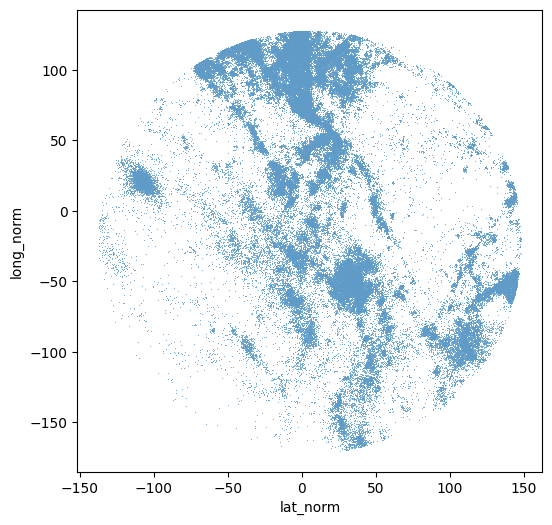

In [25]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=main_df, x="lat_norm", y = "long_norm", s=0.5 )

### Engineering the time data

In [26]:
main_df['time'] = pd.to_datetime(main_df['time'])

main_df['year'] = main_df['time'].dt.year
main_df['month'] = main_df['time'].dt.month

### Creating the Energy feature from Magnitude

In [30]:
main_df['energy'] = 10 ** (4.4 + main_df['magnitude'])

### Putting together a lattice of points to measure

In [32]:
lat_grid = (np.linspace(33.00, 35.00, 21) - 34) * 109
long_grid = (np.linspace(-117.00, -119.00, 21) + 118) * 92

#https://stackoverflow.com/questions/1208118/using-numpy-to-build-an-array-of-all-combinations-of-two-arrays
grid_geo = np.array(np.meshgrid(lat_grid, long_grid)).T.reshape(-1,2)
len(grid_geo)

441

### Calculate distance

In [33]:
import math

In [34]:
for month in range(1,13):
    print(month)

1
2
3
4
5
6
7
8
9
10
11
12


In [39]:
import warnings
warnings.filterwarnings("ignore")

In [40]:
energy_df = pd.DataFrame((grid_geo[:,0], grid_geo[:,1])).T
energy_df.columns = ['Latitude','Longitude']

for year in range(1971,2024):
    for month in range(1,13):    
        df = main_df[(main_df['year']==year) & (main_df['month']==month)].reset_index(drop=True)
        point_energy_list = []
        for j in grid_geo:
            point_energy=0
            for i in range(0,len(df)):
                if (math.dist(j,df['gridpoint'][i]) < 1):
                    distance = 1
                else: 
                    distance = math.dist(j,df['gridpoint'][i])
                magnitude = df['magnitude'][i]
                energy = 10 ** (4.4 + 1.5 * (magnitude/distance))
                point_energy += energy
            point_energy_list.append(point_energy)
        energy_df[f"{year}_{month}"] = point_energy_list



In [41]:
energy_df

,Latitude,Longitude,1971_1,1971_2,1971_3,1971_4,1971_5,1971_6,1971_7,1971_8,1971_9,1971_10,1971_11,1971_12,1972_1,1972_2,1972_3,1972_4,1972_5,1972_6,1972_7,1972_8,1972_9,1972_10,1972_11,1972_12,1973_1,1973_2,1973_3,1973_4,1973_5,1973_6,1973_7,1973_8,1973_9,1973_10,1973_11,1973_12,1974_1,1974_2,1974_3,1974_4,1974_5,1974_6,1974_7,1974_8,1974_9,1974_10,1974_11,1974_12,1975_1,1975_2,1975_3,1975_4,1975_5,1975_6,1975_7,1975_8,1975_9,1975_10,1975_11,1975_12,1976_1,1976_2,1976_3,1976_4,1976_5,1976_6,1976_7,1976_8,1976_9,1976_10,1976_11,1976_12,1977_1,1977_2,1977_3,1977_4,1977_5,1977_6,1977_7,1977_8,1977_9,1977_10,1977_11,1977_12,1978_1,1978_2,1978_3,1978_4,1978_5,1978_6,1978_7,1978_8,1978_9,1978_10,1978_11,1978_12,1979_1,1979_2,1979_3,1979_4,1979_5,1979_6,1979_7,1979_8,1979_9,1979_10,1979_11,1979_12,1980_1,1980_2,1980_3,1980_4,1980_5,1980_6,1980_7,1980_8,1980_9,1980_10,1980_11,1980_12,1981_1,1981_2,1981_3,1981_4,1981_5,1981_6,1981_7,1981_8,1981_9,1981_10,1981_11,1981_12,1982_1,1982_2,1982_3,1982_4,1982_5,1982_6,1982_7,1982_8,1982_9,1982_10,1982_11,1982_12,1983_1,1983_2,1983_3,1983_4,1983_5,1983_6,1983_7,1983_8,1983_9,1983_10,1983_11,1983_12,1984_1,1984_2,1984_3,1984_4,1984_5,1984_6,1984_7,1984_8,1984_9,1984_10,1984_11,1984_12,1985_1,1985_2,1985_3,1985_4,1985_5,1985_6,1985_7,1985_8,1985_9,1985_10,1985_11,1985_12,1986_1,1986_2,1986_3,1986_4,1986_5,1986_6,1986_7,1986_8,1986_9,1986_10,1986_11,1986_12,1987_1,1987_2,1987_3,1987_4,1987_5,1987_6,1987_7,1987_8,1987_9,1987_10,1987_11,1987_12,1988_1,1988_2,1988_3,1988_4,1988_5,1988_6,1988_7,1988_8,1988_9,1988_10,1988_11,1988_12,1989_1,1989_2,1989_3,1989_4,1989_5,1989_6,1989_7,1989_8,1989_9,1989_10,1989_11,1989_12,1990_1,1990_2,1990_3,1990_4,1990_5,1990_6,1990_7,1990_8,1990_9,1990_10,1990_11,1990_12,1991_1,1991_2,1991_3,1991_4,1991_5,1991_6,1991_7,1991_8,1991_9,1991_10,1991_11,1991_12,1992_1,1992_2,1992_3,1992_4,1992_5,1992_6,1992_7,1992_8,1992_9,1992_10,1992_11,1992_12,1993_1,1993_2,1993_3,1993_4,1993_5,1993_6,1993_7,1993_8,1993_9,1993_10,1993_11,1993_12,1994_1,1994_2,1994_3,1994_4,1994_5,1994_6,1994_7,1994_8,1994_9,1994_10,1994_11,1994_12,1995_1,1995_2,1995_3,1995_4,1995_5,1995_6,1995_7,1995_8,1995_9,1995_10,1995_11,1995_12,1996_1,1996_2,1996_3,1996_4,1996_5,1996_6,1996_7,1996_8,1996_9,1996_10,1996_11,1996_12,1997_1,1997_2,1997_3,1997_4,1997_5,1997_6,1997_7,1997_8,1997_9,1997_10,1997_11,1997_12,1998_1,1998_2,1998_3,1998_4,1998_5,1998_6,1998_7,1998_8,1998_9,1998_10,1998_11,1998_12,1999_1,1999_2,1999_3,1999_4,1999_5,1999_6,1999_7,1999_8,1999_9,1999_10,1999_11,1999_12,2000_1,2000_2,2000_3,2000_4,2000_5,2000_6,2000_7,2000_8,2000_9,2000_10,2000_11,2000_12,2001_1,2001_2,2001_3,2001_4,2001_5,2001_6,2001_7,2001_8,2001_9,2001_10,2001_11,2001_12,2002_1,2002_2,2002_3,2002_4,2002_5,2002_6,2002_7,2002_8,2002_9,2002_10,2002_11,2002_12,2003_1,2003_2,2003_3,2003_4,2003_5,2003_6,2003_7,2003_8,2003_9,2003_10,2003_11,2003_12,2004_1,2004_2,2004_3,2004_4,2004_5,2004_6,2004_7,2004_8,2004_9,2004_10,2004_11,2004_12,2005_1,2005_2,2005_3,2005_4,2005_5,2005_6,2005_7,2005_8,2005_9,2005_10,2005_11,2005_12,2006_1,2006_2,2006_3,2006_4,2006_5,2006_6,2006_7,2006_8,2006_9,2006_10,2006_11,2006_12,2007_1,2007_2,2007_3,2007_4,2007_5,2007_6,2007_7,2007_8,2007_9,2007_10,2007_11,2007_12,2008_1,2008_2,2008_3,2008_4,2008_5,2008_6,2008_7,2008_8,2008_9,2008_10,2008_11,2008_12,2009_1,2009_2,2009_3,2009_4,2009_5,2009_6,2009_7,2009_8,2009_9,2009_10,2009_11,2009_12,2010_1,2010_2,2010_3,2010_4,2010_5,2010_6,2010_7,2010_8,2010_9,2010_10,2010_11,2010_12,2011_1,2011_2,2011_3,2011_4,2011_5,2011_6,2011_7,2011_8,2011_9,2011_10,2011_11,2011_12,2012_1,2012_2,2012_3,2012_4,2012_5,2012_6,2012_7,2012_8,2012_9,2012_10,2012_11,2012_12,2013_1,2013_2,2013_3,2013_4,2013_5,2013_6,2013_7,2013_8,2013_9,2013_10,2013_11,2013_12,2014_1,2014_2,2014_3,2014_4,2014_5,2014_6,2014_7,2014_8,2014_9,2014_10,2014_11,2014_12,2015_1,2015_2,2015_3,2015_4,2015_5,2015_6,2015_7,2015_8,2015_9,2015_10,2015_11,2015_12,2016_1,2016_2,2016_3,2016_4,2016_5,2016_6,2016_7,2016_8,2016_9,20

In [43]:
energy_df.to_csv('LA_quake_energy_1971_2023.csv',index=False)